In [5]:
from hmc.state.ising_state import IsingState
from hmc.monte_carlo.ising_hmc import IsingHMC
from hmc.integrator.leap_frog import LeapFrogIntegrator
from hmc.integrator.leap_frog_autograd import LeapFrogIntegratorAutoGrad
from hmc.monte_carlo.ising_metropolis import IsingMetropolis
import numpy as np 
from matplotlib import pyplot as plt


# Example: 2D Ising Model

Here we are considering a small ($6 \times 6$) 2D Ising lattice. $J$ is the coupling between neighbouring spins, $h$ is the global external magnetic field. 

In [6]:
dim = 2 # dimension of Ising model
L = 6 # length of grid
J = 1 # spin-spin interaction coupling
h = 0  # External field

## Metropolis-Hasting MCMC with random walk

First we try the simple version of Metropolis-Hasting algorithm, where the new states are proposed by random walk.

The following code does several things :

- create an Ising state
- choose the Metropolis-Hasting MC algorithm
- define observables to be measured (here we use magnetizaiton $m$)
- sample from the distribution and record measurements 

In [7]:

beta_list = np.linspace(0.1,0.7,6*2+1)
metropolis_m_list = []
n_rounds = 10

for beta in beta_list:
    rounds_list = []
    for _ in range(n_rounds):
        state = IsingState(length=6,dim=2,beta=beta, J=J, h=h) # define ising state
        mc = IsingMetropolis(ising_state=state) # define Monte Carlo algorithm
        measurements = {"m": state.get_magnetization} # define physics observable to be measured
        # sample and generate result
        measured_result = mc.sample(measurements=measurements,n_samples=4000,n_iters_per_sample=100,n_thermalization_iters=40000)
        m_abs = np.absolute(measured_result["m"]).mean()
        rounds_list.append(m_abs)
        #print(f"beta: {beta},  magnetization: {m_abs} ")
    metropolis_m_list.append(rounds_list)    
metropolis_m_list = np.array(metropolis_m_list)


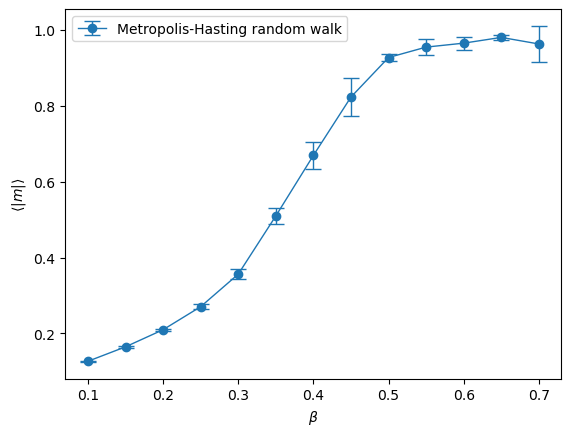

In [10]:

m_mean_metro = metropolis_m_list.mean(axis=-1)
m_std_metro = metropolis_m_list.std(axis=-1)

fig, ax = plt.subplots()
ax.errorbar(beta_list, m_mean_metro, m_std_metro, fmt='o-', linewidth=1, capsize=6, label ="Metropolis-Hasting random walk")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.legend()
fig.show()

# Hamiltonian Monte Carlo


Now since HMC involves integrate the equation of motion (EOM). we need an integrator (leap frog algorithm is used). Also, we need to define step size and the number of steps of the integrator.

In [11]:
step_size = 0.1 # step size of integrator
trajectory_length = 1
n_steps = int(trajectory_length/step_size) # number of steps in a trajectory
leap_frog = LeapFrogIntegrator(step_size, n_steps) # define integrator

We repeat the steps above with the Hamiltonian Monte Carlo algorithm. 

In [13]:

beta_list = np.linspace(0.1,0.7,6*2+1) # define beta valueus to measure
n_rounds = 10

hmc_m_list = []
for beta in beta_list:
    rounds_list = []
    for _ in range(n_rounds):
        state = IsingState(length=6,dim=2,beta=beta, J=J, h=h) # define ising state
        mc = IsingHMC(ising_state=state,integrator=leap_frog) # define Monte Carlo algorithm
        measurements = {"m": state.get_magnetization} # define physics observable to be measured
        # sample and generate result
        measured_result = mc.sample(measurements=measurements,n_samples=400,n_iters_per_sample=10,n_thermalization_iters=100)
        m_abs = np.absolute(measured_result["m"]).mean()
        rounds_list.append(m_abs)
    hmc_m_list.append(rounds_list)      
hmc_m_list = np.array(hmc_m_list)

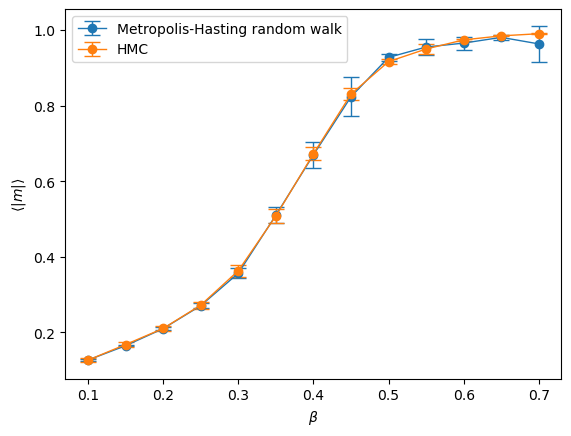

In [16]:

m_mean_hmc = hmc_m_list.mean(axis=-1)
m_std_hmc = hmc_m_list.std(axis=-1)

fig, ax = plt.subplots()
ax.errorbar(beta_list, m_mean_metro, m_std_metro, fmt='o-', linewidth=1, capsize=6, label="Metropolis-Hasting random walk" )
ax.errorbar(beta_list, m_mean_hmc, m_std_hmc, fmt='o-', linewidth=1, capsize=6, label="HMC")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.legend()
fig.show()

# Hamiltonian Monte Carlo - Pytorch Autograd

Using Pytorch autograd to obtain gradient value is generally slower. However, it may cope with more complex Hamiltonian. 

Since the only difference of HMC-Autograd and HMC is that HMC-Autograd use PyTorch Autograd to calculate gradient value. Their prediction should not be different. Here, in order to verify the performance of HMC-Autograd, we repeat the experiment above.

In [17]:
beta_list = np.linspace(0.1,0.7,6*2+1) # define beta valueus to measure
n_rounds = 10



step_size = 0.1
trajectory_length = 1
n_steps = int(trajectory_length/step_size)
leap_frog = LeapFrogIntegratorAutoGrad(step_size, n_steps)
beta_list = np.linspace(0.1,0.7,6*2+1)
autograd_m_list = []

for beta in beta_list:
    rounds_list = []
    for _ in range(n_rounds):
        state = IsingState(length=6,dim=2,beta=beta, J=J, h=h)
        mc = IsingHMC(ising_state=state,integrator=leap_frog,autograd=True)
        measurements = {"m": state.get_magnetization}
        measured_result = mc.sample(measurements=measurements,n_samples=400,n_iters_per_sample=10,n_thermalization_iters=100)
        m_abs = np.absolute(measured_result["m"]).mean()
        rounds_list.append(m_abs)
    autograd_m_list.append(rounds_list)
autograd_m_list = np.array(autograd_m_list)

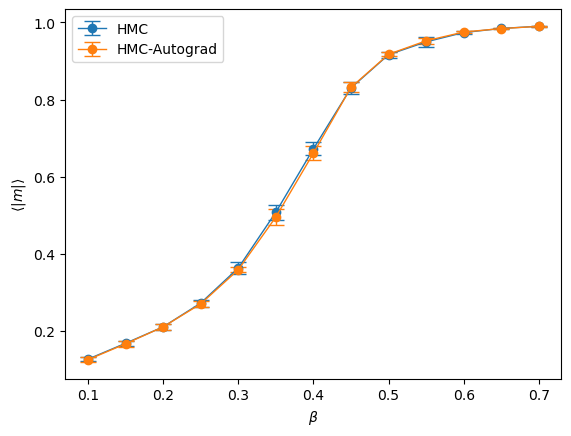

In [18]:
m_mean_autograd = autograd_m_list.mean(axis=-1)
m_std_autograd = autograd_m_list.std(axis=-1)

fig, ax = plt.subplots()
ax.errorbar(beta_list, m_mean_hmc, m_std_hmc, fmt='o-', linewidth=1, capsize=6, label="HMC")
ax.errorbar(beta_list, m_mean_autograd, m_std_autograd, fmt='o-', linewidth=1, capsize=6, label="HMC-Autograd")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.legend()
fig.show()